In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
from scikeras.wrappers import KerasClassifier
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt


In [ ]:
#function for playing sound
def play_sound():
    mixer.init()
    mixer.music.load('done-for-you.mp3')
    mixer.music.play()
    
def resize_and_normalize_image(image):
    image = tf.image.resize(image,[96,96])
    image = tf.image.rgb_to_grayscale(image)
    return image / 255.0

def convert_sample(data):

# Create a TensorFlow dataset from the training data features
    dataset = tf.data.Dataset.from_tensor_slices(data)

# Define a function to resize each image in the dataset

# Apply the resize function to each image in the dataset
    resized_dataset = dataset.map(resize_and_normalize_image)

# Convert the resized dataset to a NumPy array
    resized_arr = np.array(list(resized_dataset.as_numpy_iterator()))

    return resized_arr

import matplotlib.pyplot as plt

def plot_histories(histories, names, measure='loss'):
    
    measure_to_pretty = {'loss': 'Loss', 
                         'accuracy': 'Accuracy'}
    nb_histories = len(histories)
    
    fig = plt.figure(figsize=plt.figaspect(0.05 * nb_histories))
    
    for i in range(nb_histories):
        ax = fig.add_subplot(1, nb_histories, i + 1)
        
        # Plot validation data if it exists
        if measure == 'loss':  # Special case for loss
            if 'val_loss' in histories[i].history:
                ax.plot(histories[i].history['val_loss'], label=f'Val Loss, {names[i]}')
            ax.plot(histories[i].history['loss'], label=f'Training Loss, {names[i]}')
        elif measure == 'accuracy':  # For accuracy
            if 'val_accuracy' in histories[i].history:
                ax.plot(histories[i].history['val_accuracy'], label=f'Val Accuracy, {names[i]}')
            ax.plot(histories[i].history['accuracy'], label=f'Training Accuracy, {names[i]}')

        # Set labels and limits
        ax.set_xlabel('Epoch')
        ax.set_ylabel(measure_to_pretty.get(measure, measure))
        ax.legend()
        ax.set_xlim(0, xlim_max)
        ax.set_ylim(ylim_min, ylim_max)

    plt.tight_layout()
    plt.show()


In [ ]:
# Load the training data features
X_train_raw = np.load('data/Xtrain.npy')
print(f'Shape of the raw training data: {X_train_raw.shape}')
X_test_raw = np.load('data/Xtest.npy')
print(f'Shape of the raw test data: {X_test_raw.shape}')

X_train = convert_sample(X_train_raw)
print(f'Shape the resized training data: {X_train.shape}')

X_test = convert_sample(X_test_raw)
print(f'Shape the resized test data: {X_test.shape}')

y_raw = np.load('ytrain.npy')
y_raw = y_raw.reshape(-1,1) 
print(f'Shape of the raw labels: {y_raw.shape}')

Shape of the raw training data: (26214, 96, 96, 3)
Shape of the raw test data: (1638, 96, 96, 3)
Shape the resized training data: (26214, 96, 96, 1)
Shape the resized test data: (1638, 96, 96, 1)
Shape of the raw labels: (26214, 1)


2024-10-25 00:18:21.349461: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
x_train = X_train[:5000]
y_train = y_raw[:5000]
print(f'x train: {x_train.shape}')
print(f'y train: {y_train.shape}')

x_val = X_train[25000:]
y_val = y_raw[25000:]
print(f'x val: {x_val.shape}')
print(f'y val: {y_val.shape}')

x train: (5000, 96, 96, 1)
y train: (5000, 1)
x val: (1214, 96, 96, 1)
y val: (1214, 1)


### Hyperparameter tuning

Question (adapted from the exam):
Use FCNN to perform image classification (tumor detection). Consider among other things the following:
1. Different activation functions
2. Different number of layers
3. Different number of neurons in each layer
4. Different learning rates
5. Different batch sizes
6. Different number of epochs
7. Different optimizers

In [ ]:
def build_model(size, activation, w_regularizer, dropout, batch_norm):
    layers = [tf.keras.layers.Flatten(input_shape=(32,32,1))]
    
    nb_layers = size
    nb_neurons = size ** 2 * 4
    
    for i in range(nb_layers):
        layers.append(tf.keras.layers.Dense(nb_neurons, 
                                            activation=activation, 
                                            kernel_regularizer=w_regularizer))
        if batch_norm:
            layers.append(tf.keras.layers.BatchNormalization())
        if dropout:
            layers.append(tf.keras.layers.Dropout(0.2))

    layers.append(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    model = tf.keras.models.Sequential(layers)

    sgd_opt = SGD(learning_rate=0.01, momentum=0.5, nesterov=True)

    model.compile(optimizer=sgd_opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    
    return model

In [ ]:
def create_model():
    # create model
    model = Sequential()
    model.add(Input(shape=(96, 96, 1)))  # Specify the input shape here
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    # Compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

seed = 7
tf.random.set_seed(seed)

#### Tune Batch Size and Number of Epochs

In [ ]:
model = KerasClassifier(model=create_model, verbose=0)

In [ ]:
batch_size = [10, 50]
epochs = [40, 60]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

In [ ]:
grid_result = grid.fit(x_train, y_train)

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.503000 using {'batch_size': 10, 'epochs': 40}


In [ ]:
#['200', 250, 300] ->64
#[185, '210'] -> 61
#[210, '220'] -> 63.8
#[220, 230] -> 62
#['235', 240] -> 61
batch_size = [190]
#['65', 75] -> 64
#['60', 70] -> 61
#[55, '64'] -> 63.8
#[62, 66] -> 62
#['60', 63] -> 61
epochs = [57, 60, 62, 65, 69]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

In [ ]:
grid_result = grid.fit(x_train, y_train)

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.632397 using {'batch_size': 190, 'epochs': 62}


In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
#Best: 0.634600 using {'batch_size': 200, 'epochs': 62}
#Best: 0.632397 using {'batch_size': 190, 'epochs': 62} !!
#Best: 0.642404 using {'batch_size': 190, 'epochs': 60}
#Best: 0.643198 using {'batch_size': 200, 'epochs': 65}
#Best: 0.641202 using {'batch_size': 190, 'epochs': 65}
#Best: 0.642001 using {'batch_size': 190, 'epochs': 57}

Best: 0.632999 using {'batch_size': 190, 'epochs': 57}
0.632999 (0.005800) with: {'batch_size': 190, 'epochs': 57}
0.628398 (0.008932) with: {'batch_size': 190, 'epochs': 60}
0.627405 (0.016206) with: {'batch_size': 190, 'epochs': 62}
0.605202 (0.008580) with: {'batch_size': 190, 'epochs': 65}
0.626403 (0.011461) with: {'batch_size': 190, 'epochs': 69}


### Tune the Training Optimization Algorithm

In [ ]:
def create_model(optimizer):
    # create model
    model = Sequential()
    model.add(Input(shape=(32, 32, 1)))  # Specify the input shape here
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

seed = 7
tf.random.set_seed(seed)

In [ ]:
model = KerasClassifier(model=create_model, epochs=57, batch_size=190, verbose=0)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(model__optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

In [ ]:
grid_result = grid.fit(x_train, y_train)

2024-10-24 22:06:57.374780: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GP2024-10-24 22:06:57.374778: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GP2024-10-24 22:06:57.374786: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
U will not be used.
U will not be used.
2024-10-24 22:06:57.378650: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GP2024-10-24 22:06:57.378653: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GP2024-10-24 22:06:57.378653: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
U will not be used.
U will not be used.
2024-10-24 22:06:57.389960: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cu

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.675403 using {'model__optimizer': 'Adamax'}
0.577791 (0.038575) with: {'model__optimizer': 'SGD'}
0.555008 (0.031885) with: {'model__optimizer': 'RMSprop'}
0.561803 (0.017244) with: {'model__optimizer': 'Adagrad'}
0.547396 (0.014190) with: {'model__optimizer': 'Adadelta'}
0.625598 (0.012033) with: {'model__optimizer': 'Adam'}
0.675403 (0.011796) with: {'model__optimizer': 'Adamax'}
0.609205 (0.035867) with: {'model__optimizer': 'Nadam'}


SGD optimizer

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.2)

In [ ]:
def create_model():
    # create model
    model = Sequential()
    model.add(Input(shape=(32, 32, 1)))  # Specify the input shape here
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    return model

In [ ]:
model = KerasClassifier(model=create_model, loss='sparse_categorical_crossentropy', optimizer="SGD", epochs=57, batch_size=190, verbose=0)


learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(optimizer__learning_rate=learn_rate, optimizer__momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

In [ ]:
grid_result = grid.fit(x_train, y_train)

2024-10-24 22:09:20.431821: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 22:09:20.440336: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 22:09:20.464656: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 22:09:20.507394: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 22:09:20.518185: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 22:09:20.547231: I tensorflow/core/platform/cpu_feature_gu

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.673194 using {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.8}
0.547001 (0.013213) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.0}
0.550401 (0.006716) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.2}
0.577597 (0.011897) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.4}
0.576996 (0.017274) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.6}
0.581601 (0.004439) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.8}
0.624197 (0.011022) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.9}
0.567197 (0.033294) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.0}
0.575607 (0.053323) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.2}
0.611008 (0.056227) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.4}
0.579808 (0.041729) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.6}
0.673194 (0.021686) 

In [ ]:
def create_model(init_mode='uniform'):
    # create model
    model = Sequential()
    model.add(Input(shape=(32, 32, 1)))  # Specify the input shape here
    model.add(Flatten())
    model.add(Dense(256, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(512, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(128, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(2, kernel_initializer=init_mode, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='Adamax', metrics=['accuracy'])

    return model

seed = 7
tf.random.set_seed(seed)

In [ ]:
model = KerasClassifier(model=create_model, epochs=57, batch_size=190, verbose=0)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(model__init_mode=init_mode)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

In [ ]:
grid_result = grid.fit(x_train, y_train)

2024-10-24 23:05:52.236512: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 23:05:52.240796: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 23:05:52.248680: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 23:05:52.252830: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 23:05:52.253314: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 23:05:52.255056: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 23:05:52.255128: I external/local_xla/x

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.681601 using {'model__init_mode': 'normal'}
0.638602 (0.009101) with: {'model__init_mode': 'uniform'}
0.667398 (0.006480) with: {'model__init_mode': 'lecun_uniform'}
0.681601 (0.004342) with: {'model__init_mode': 'normal'}
0.503000 (0.000245) with: {'model__init_mode': 'zero'}
0.666003 (0.013457) with: {'model__init_mode': 'glorot_normal'}
0.669801 (0.004107) with: {'model__init_mode': 'glorot_uniform'}
0.671400 (0.004777) with: {'model__init_mode': 'he_normal'}
0.674397 (0.009941) with: {'model__init_mode': 'he_uniform'}


### Tune the Neuron Activation Function

In [ ]:
def create_model(activation='relu'):
    # create model
    model = Sequential()
    model.add(Input(shape=(32, 32, 1)))  # Specify the input shape here
    model.add(Flatten())
    model.add(Dense(256, activation=activation))
    model.add(Dense(512, activation=activation))
    model.add(Dense(128,  activation=activation))
    model.add(Dense(2,  activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='Adamax', metrics=['accuracy'])

    return model

seed = 7
tf.random.set_seed(seed)

In [ ]:
model = KerasClassifier(model=create_model, epochs=57, batch_size=190, verbose=0)
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(model__activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

In [ ]:
grid_result = grid.fit(x_train, y_train)

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.678000 using {'model__activation': 'relu'}
0.503000 (0.000245) with: {'model__activation': 'softmax'}
0.617392 (0.033047) with: {'model__activation': 'softplus'}
0.594197 (0.012120) with: {'model__activation': 'softsign'}
0.678000 (0.007617) with: {'model__activation': 'relu'}
0.621198 (0.007917) with: {'model__activation': 'tanh'}
0.566398 (0.022313) with: {'model__activation': 'sigmoid'}
0.627599 (0.012355) with: {'model__activation': 'hard_sigmoid'}
0.539795 (0.017104) with: {'model__activation': 'linear'}


### How to Tune Dropout Regularization

In [ ]:
def create_model(dropout_rate, weight_constraint):
    # create model
    model = Sequential()
    model.add(Input(shape=(32, 32, 1)))  # Specify the input shape here
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_constraint=MaxNorm(weight_constraint)))
    model.add(Dense(512, activation='relu', kernel_constraint=MaxNorm(weight_constraint)))
    model.add(Dense(128, activation='relu', kernel_constraint=MaxNorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='Adamax', metrics=['accuracy'])

    return model

seed = 7
tf.random.set_seed(seed)

In [ ]:
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.layers import Dropout

model = KerasClassifier(model=create_model, epochs=90, batch_size=70, verbose=0)
weight_constraint = [1.0, 2.0, 3.0, 4.0, 5.0]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(model__dropout_rate=dropout_rate, model__weight_constraint=weight_constraint)
#param_grid = dict(model__dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

2024-10-24 23:11:35.792333: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 23:11:35.800235: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 23:11:35.807535: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 23:11:35.814172: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 23:11:35.825553: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 23:11:35.835994: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.691997 using {'model__dropout_rate': 0.2, 'model__weight_constraint': 4.0}
0.688398 (0.007776) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 1.0}
0.681599 (0.010773) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 2.0}
0.681802 (0.013101) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 3.0}
0.688999 (0.022138) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 4.0}
0.678200 (0.018126) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 5.0}
0.678397 (0.012818) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 1.0}
0.686201 (0.006058) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 2.0}
0.672601 (0.025370) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 3.0}
0.683798 (0.007427) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 4.0}
0.680995 (0.018981) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 5.0}
0.681798 (0.017233) with: {'model__dr

### Tune the Number of Neurons in the Hidden Layer

In [ ]:
def create_model(neurons_1, neurons_2, neurons_3):
    # create model
    model = Sequential()
    model.add(Input(shape=(32, 32, 1)))  # Specify the input shape here
    model.add(Flatten())
    model.add(Dense(neurons_1, activation='relu', kernel_constraint=MaxNorm(4)))
    model.add(Dense(neurons_2, activation='relu', kernel_constraint=MaxNorm(4)))
    model.add(Dense(neurons_3, activation='relu', kernel_constraint=MaxNorm(4)))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='Adamax', metrics=['accuracy'])

    return model

seed = 7
tf.random.set_seed(seed)

In [ ]:
model = KerasClassifier(model=create_model, epochs=57, batch_size=190, verbose=0)

#Best: 0.689800 using {'model__neurons_1': 200, 'model__neurons_2': 600, 'model__neurons_3': 100}
#Best: 0.678000 using {'model__neurons_1': 150, 'model__neurons_2': 550, 'model__neurons_3': 95}
#Best: 0.688798 using {'model__neurons_1': 140, 'model__neurons_2': 560, 'model__neurons_3': 90}
#Best: 0.688196 using {'model__neurons_1': 135, 'model__neurons_2': 555, 'model__neurons_3': 90}
#Best: 0.684795 using {'model__neurons_1': 130, 'model__neurons_2': 558, 'model__neurons_3': 90}
# define the grid search parameters
neurons_1 = [200, 300]   # Options for the first hidden layer
neurons_2 = [600, 700, 800]   # Options for the second hidden layer
neurons_3 = [100, 200]

param_grid = dict(model__neurons_1=neurons_1, 
                  model__neurons_2=neurons_2, 
                  model__neurons_3=neurons_3)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

2024-10-25 00:10:30.031251: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-25 00:10:30.035876: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-25 00:10:30.286975: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-25 00:10:30.307706: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-25 00:10:30.313729: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-25 00:10:30.329903: I tensorflow/core/platform/cpu_feature_gu

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.691600 using {'model__neurons_1': 200, 'model__neurons_2': 700, 'model__neurons_3': 200}
0.671799 (0.008108) with: {'model__neurons_1': 200, 'model__neurons_2': 600, 'model__neurons_3': 100}
0.674398 (0.008914) with: {'model__neurons_1': 200, 'model__neurons_2': 600, 'model__neurons_3': 200}
0.684399 (0.005364) with: {'model__neurons_1': 200, 'model__neurons_2': 700, 'model__neurons_3': 100}
0.691600 (0.009353) with: {'model__neurons_1': 200, 'model__neurons_2': 700, 'model__neurons_3': 200}
0.682997 (0.014039) with: {'model__neurons_1': 200, 'model__neurons_2': 800, 'model__neurons_3': 100}
0.684802 (0.009862) with: {'model__neurons_1': 200, 'model__neurons_2': 800, 'model__neurons_3': 200}
0.653000 (0.003186) with: {'model__neurons_1': 300, 'model__neurons_2': 600, 'model__neurons_3': 100}
0.674400 (0.002218) with: {'model__neurons_1': 300, 'model__neurons_2': 600, 'model__neurons_3': 200}
0.657000 (0.013025) with: {'model__neurons_1': 300, 'model__neurons_2': 700, 'model__ne

## Testing

In [ ]:
model = Sequential()
model.add(Input(shape=(96, 96, 1)))  # Specify the input shape here
model.add(Flatten())
model.add(Dense(180, activation='relu', kernel_constraint=MaxNorm(4)))
model.add(Dense(658, activation='relu', kernel_constraint=MaxNorm(4)))
model.add(Dense(190, activation='relu', kernel_constraint=MaxNorm(4)))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            patience=3, 
                                            restore_best_weights=True)

In [ ]:
model.fit(X_train, y_raw, epochs=57, batch_size=190, validation_split=0.2)

Epoch 1/57
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5003 - loss: 1.1312 - val_accuracy: 0.4946 - val_loss: 0.6932
Epoch 2/57
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5057 - loss: 0.6929 - val_accuracy: 0.4763 - val_loss: 0.6911
Epoch 3/57
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5147 - loss: 0.6915 - val_accuracy: 0.4766 - val_loss: 0.6903
Epoch 4/57
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5171 - loss: 0.6907 - val_accuracy: 0.4871 - val_loss: 0.6890
Epoch 5/57
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5185 - loss: 0.6907 - val_accuracy: 0.5192 - val_loss: 0.6881
Epoch 6/57
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5224 - loss: 0.6885 - val_accuracy: 0.5518 - val_loss: 0.6871
Epoch 7/57
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5358 - loss: 0.6870 - val_accuracy: 0.5817 - val_loss: 0.6902
Epoch 8/57
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5383 - loss: 0.6863 - val_accu

In [ ]:
y_test_hat = model.predict(X_test)
y_test_hat = np.argmax(y_test_hat, axis=1)

ytest_hat_pd = pd.DataFrame({
    'Id': list(range(len(y_test_hat))),
    'Predicted': y_test_hat.reshape(-1,),
})

ytest_hat_pd.to_csv('y_test_hat_fcnn.csv', index=False)

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
model1 = model.fit(X_train, y_raw, epochs=57, batch_size=190, validation_split=0.2)

Epoch 1/57
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5150 - loss: 0.7123 - val_accuracy: 0.5567 - val_loss: 0.6874
Epoch 2/57
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5758 - loss: 0.6799 - val_accuracy: 0.6090 - val_loss: 0.6738
Epoch 3/57
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6005 - loss: 0.6674 - val_accuracy: 0.6616 - val_loss: 0.6534
Epoch 4/57
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6749 - loss: 0.6343 - val_accuracy: 0.6660 - val_loss: 0.6249
Epoch 5/57
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7192 - loss: 0.5854 - val_accuracy: 0.6868 - val_loss: 0.5966
Epoch 6/57
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7369 - loss: 0.5445 - val_accuracy: 0.6901 - val_loss: 0.5924
Epoch 7/57
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7523 - loss: 0.5162 - val_accuracy: 0.6912 - val_loss: 0.5826
Epoch 8/57
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7602 - loss: 0.4978 - val_accuracy: 0.

In [ ]:
print(model1.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


NameError: name 'xlim_max' is not defined

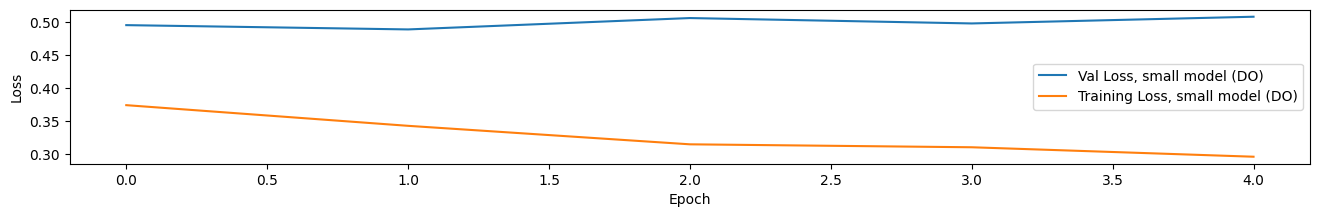

In [ ]:

plot_histories(histories=[model1], 
               names=['small model (DO)'], 
               measure='loss')
plot_histories(histories=[model1], 
               names=['small model (DO)'], 
               measure='accuracy')

In [ ]:
y_test_hat = model.predict(X_test)
y_test_hat = np.argmax(y_test_hat, axis=1)

ytest_hat_pd = pd.DataFrame({
    'Id': list(range(len(y_test_hat))),
    'Predicted': y_test_hat.reshape(-1,),
})

ytest_hat_pd.to_csv('y_test_hat_fcnn.csv', index=False)

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
